## CA 2, LLMs Spring 2024

- **Name: Bardia Khalafi**
- **Student ID: 810199414**

---
#### Your submission should be named using the following format: `CA2_LASTNAME_STUDENTID_gpt.ipynb`.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TA via email:
sepehr.kamahi@ut.ac.ir

---

## Section 1: Generate a Single Sentence (20 points)
Write a prompt that has ten tokens according to the GPT-2 tokenizer. (2 points)

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import time
model_name = "gpt2"

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
prompt = "Tell me a funny story about a cute cat."

tokenized_prompt = tokenizer(prompt, return_tensors="pt")
print(tokenized_prompt['input_ids'].size(), tokenized_prompt)
## print the tokens, input_ids, and attention_mask

torch.Size([1, 10]) {'input_ids': tensor([[24446,   502,   257,  8258,  1621,   546,   257, 13779,  3797,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


### a) Load the model to the GPU
Use the prompt you wrote and generate 190 new tokens, appending each new token to the previous sequence at each step. Measure the time of generating each new token. You CAN ONLY use PyTorch for decoding; use greedy decoding. You will get a 200-token sequence at the end, so print the sentence.

Plot the time needed for generating each new token. Use torch.cuda.max_memory_allocated and plot the memory used at each step in MB. At each step, by giving the input_ids to the model as the labels argument, the loss will be calculated for you automatically. Plot the loss at all steps.
(compute loss only for this part of the assignment)

Explain the patterns you see in the plots. (8 points)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
import matplotlib.pyplot as plt
import time

input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
MAX_TOKENS = 200

memory_allocated = []
losses = []
times_normal = []

In [6]:
start_time = time.time()

with torch.no_grad():
    while len(input_ids[0]) < MAX_TOKENS:
        start_step_time = time.time()

        outputs = model(input_ids)
        logits = outputs.logits[:, -1, :]
        predicted_token_id = torch.argmax(logits, dim=-1)
        step_time = time.time() - start_step_time
        times_normal.append(step_time)

        # Append the predicted token to input_ids
        input_ids = torch.cat([input_ids, predicted_token_id.unsqueeze(0)], dim=-1)

        # Calculate loss (optional)
        loss = torch.nn.functional.cross_entropy(logits, predicted_token_id)
        losses.append(loss.item())

        # Store memory allocated
        memory_allocated.append(torch.cuda.memory_allocated() / (1024 ** 2))  # Convert bytes to MB
end_time = time.time() - start_time
print(f"Total Time with past_key_values: {end_time:.2f} seconds")


Total Time with past_key_values: 9.74 seconds


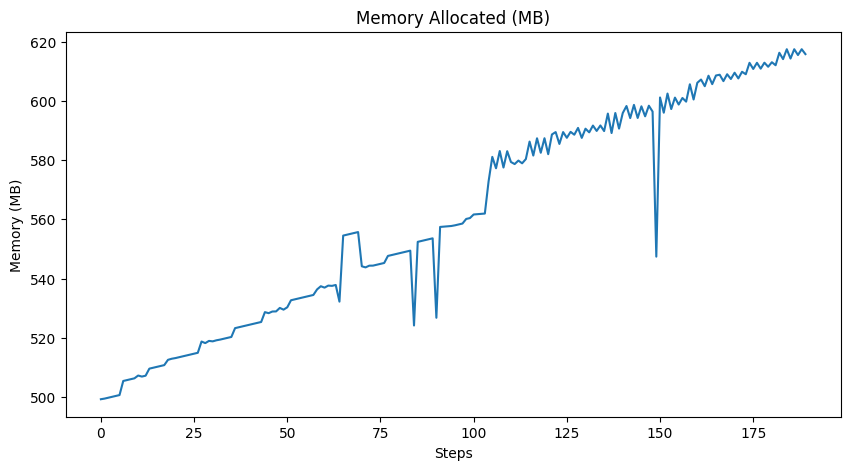

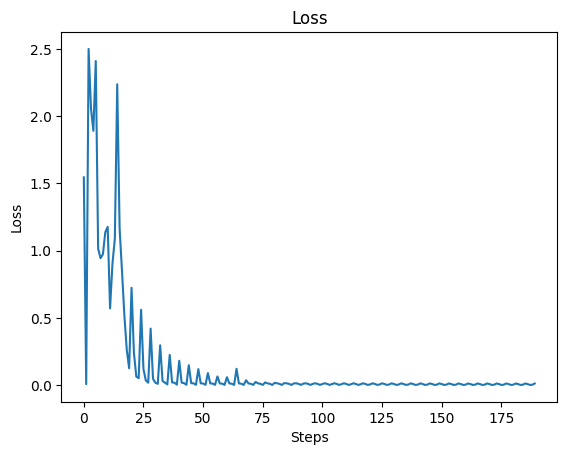

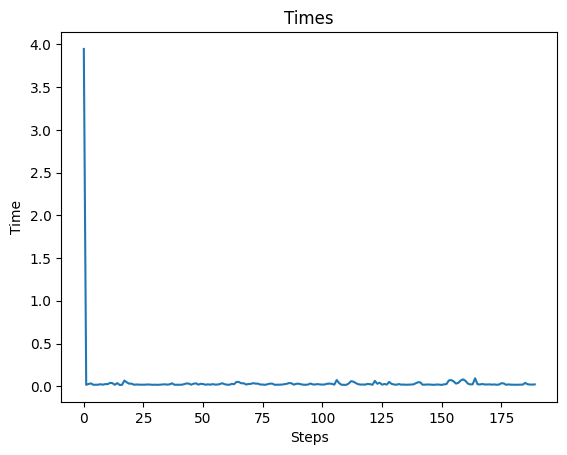

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(memory_allocated)
plt.title("Memory Allocated (MB)")
plt.xlabel("Steps")
plt.ylabel("Memory (MB)")
plt.show()

plt.plot(losses)
plt.title("Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

plt.plot(times_normal)
plt.title("Times")
plt.xlabel("Steps")
plt.ylabel("Time")
plt.show()

plt.tight_layout()
plt.show()


In [8]:
torch.cuda.empty_cache()

### b) Use past_key_values
Give the past_key_values to the model during generation, and repeat all of the above steps; then, compare the results. (10 points)

In [9]:
memory_allocated = []
losses = []
times = []

In [10]:
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

In [11]:
start_time = time.time()
with torch.no_grad():
    past_key_values = None
    while len(input_ids[0]) < MAX_TOKENS:
        start_step_time = time.time()
        output = model(input_ids, past_key_values=past_key_values)
        logits = outputs.logits[:, -1, :]
        predicted_token_id = torch.argmax(logits, dim=-1)
        step_time = time.time() - start_step_time
        times.append(step_time)

        # Append the predicted token to input_ids
        input_ids = torch.cat([input_ids, predicted_token_id.unsqueeze(0)], dim=-1)

        # Update the past_key_values
        past_key_values = outputs.past_key_values

        # Calculate loss (optional)
        loss = torch.nn.functional.cross_entropy(logits, predicted_token_id)
        losses.append(loss.item())

        # Store memory allocated
        memory_allocated.append(torch.cuda.memory_allocated() / (1024 ** 2))  # Convert bytes to MB

    end_time_past_key_value = time.time() - start_time
    print(f"Total Time with past_key_values: {end_time_past_key_value:.2f} seconds")

Total Time with past_key_values: 5.15 seconds


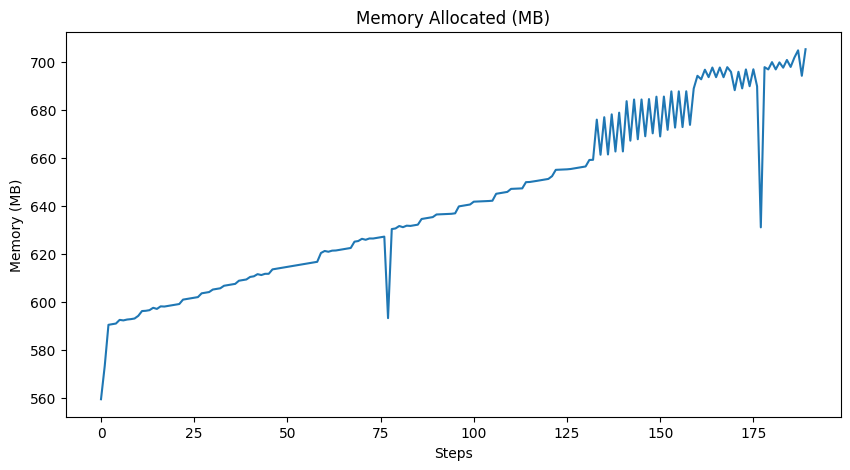

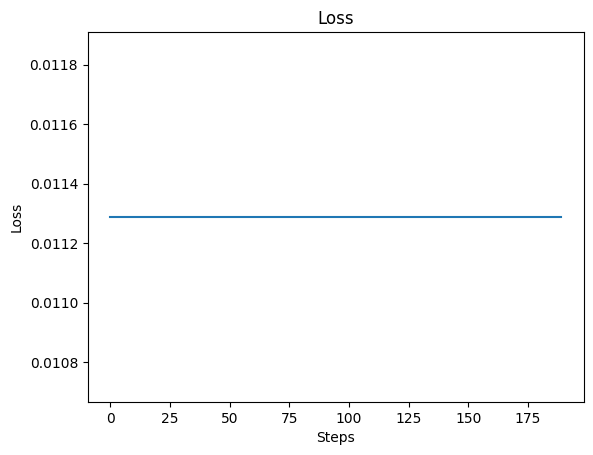

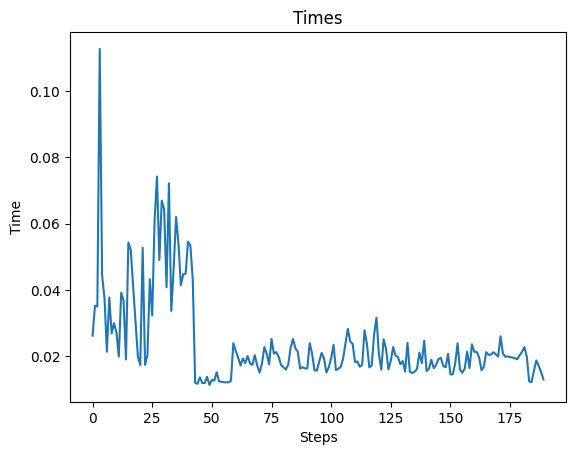

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 5))

plt.plot(memory_allocated)
plt.title("Memory Allocated (MB)")
plt.xlabel("Steps")
plt.ylabel("Memory (MB)")
plt.show()

plt.plot(losses)
plt.title("Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

plt.plot(times)
plt.title("Times")
plt.xlabel("Steps")
plt.ylabel("Time")
plt.show()

plt.tight_layout()
plt.show()


There is a tradeoff here

with using the past_key_value, the model states and its previous calculations is saved into the memory so it will use more memory and the loss doesnt change, but it will increase the inference speed.

and the sudden drop in memory is probably because the cache of saved calculatiosn were cleared once.

In [13]:
torch.cuda.empty_cache()

## Section 2: Batch Generation (25 points)
Write 4 prompts (a list of 4 sentences). All the sentences you write should have different lengths. Print the input_ids and attention_mask, and explain why the attention_masks are the way they are. When you tokenize, use left-side padding. Explain why left-side padding is preferable during inference. What is the padding token ID in this particular tokenizer?
(10 points)

In [14]:
def tokenize_with_left_padding(prompt, tokenizer, max_length):
    inputs = tokenizer.encode_plus(
            prompt,
            None,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=True
    )
    n_tokens = max_length - len(inputs['input_ids'])
    pad_tokens_tensor = torch.full((n_tokens,), tokenizer.pad_token_id, dtype=torch.long)
    inputs['input_ids'] = torch.cat((pad_tokens_tensor, torch.tensor(inputs['input_ids'])), dim=-1)
    inputs['attention_mask'] = torch.cat((pad_tokens_tensor, torch.tensor(inputs['attention_mask'])), dim=-1)
    return inputs

In [15]:
prompts_list = [
    'Write a story for me.',
    'Hello Mr GPT!',
    'Who is the best player in soccer?',
    'Hi, how was your day my friend?'
]

print(tokenizer(prompts_list))

tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
max_length = 60
normal_padding_encoded_prompts = []
print('Normal padding')
for prompt in prompts_list:
    encoded_prompt = tokenizer.encode(prompt, return_tensors='pt', max_length=max_length, truncation=True)
    normal_padding_encoded_prompts.append(encoded_prompt)
print(normal_padding_encoded_prompts)

left_padding_encoded_prompts = []
print('Left padding')
for prompt in prompts_list:
    encoded_prompt = tokenize_with_left_padding(prompt, tokenizer, max_length=max_length)
    left_padding_encoded_prompts.append(encoded_prompt)
print(left_padding_encoded_prompts)

{'input_ids': [[16594, 257, 1621, 329, 502, 13], [15496, 1770, 402, 11571, 0], [8241, 318, 262, 1266, 2137, 287, 11783, 30], [17250, 11, 703, 373, 534, 1110, 616, 1545, 30]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}
Normal padding
[tensor([[16594,   257,  1621,   329,   502,    13]]), tensor([[15496,  1770,   402, 11571,     0]]), tensor([[ 8241,   318,   262,  1266,  2137,   287, 11783,    30]]), tensor([[17250,    11,   703,   373,   534,  1110,   616,  1545,    30]])]
Left padding
[{'input_ids': tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,

In [16]:
tokenizer.pad_token_id

0

attention masks are initialized with 1 for input because all the tokens in input should attend

left side padding helps the model input to be consistant in size and prevent errors cause by input sizes and helps the batch process because of the constant input size.

and its better than right size padding because of the attention mechanism ( the padding tokens are the first tokens to process so model can skip them and dont waste computation time )

left side padding allows us to do batch process sequences with different lengths. With left side padding, we can stack sequences into a batch tensor without needing to adjust the positions of the tokens within each sequence
and you can append new generated tokens at the last and shift the values


For batch decoding, you should also give position_ids to the model. You should create the position_ids yourself. Explain what position_ids are and how they help. Print the position_ids of your batch prompt. Repeat Section 1, Subsection b, but this time, use the prompt in batch form and give position_ids to the model. Plot the memory needed at each step. Plot the time needed at each step, also plot number of tokens generated per second (a.k.a. throughput). Compare the throughput and memory usage of batch generation with single sentence generation. (15 points)

In [17]:
def create_position_ids(batch_inputs):
    position_ids = []
    for inputs in batch_inputs:
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        num_tokens = input_ids.size(0)
        positions = []
        pos_id = 0
        for i in range(num_tokens):
            if attention_mask[i] == 0:
                positions.append(1)
            elif attention_mask[i] == 1 and pos_id == 1:
                positions.append(1)
                pos_id += 1
            else:
                positions.append(pos_id)
                pos_id += 1
        position_ids.append(torch.tensor(positions))
    return position_ids

In [18]:
position_ids = create_position_ids(left_padding_encoded_prompts)
print(position_ids)

[tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 2, 3, 4, 5]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 3, 4]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 2, 3, 4, 5, 6, 7]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8])]


In [19]:
left_padding_encoded_prompts

[{'input_ids': tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0, 16594,   257,  1621,   329,   502,    13]), 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])},
 {'input_ids': tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,  

torch.Size([4, 60])
Total Time with past_key_values: 10.61 seconds


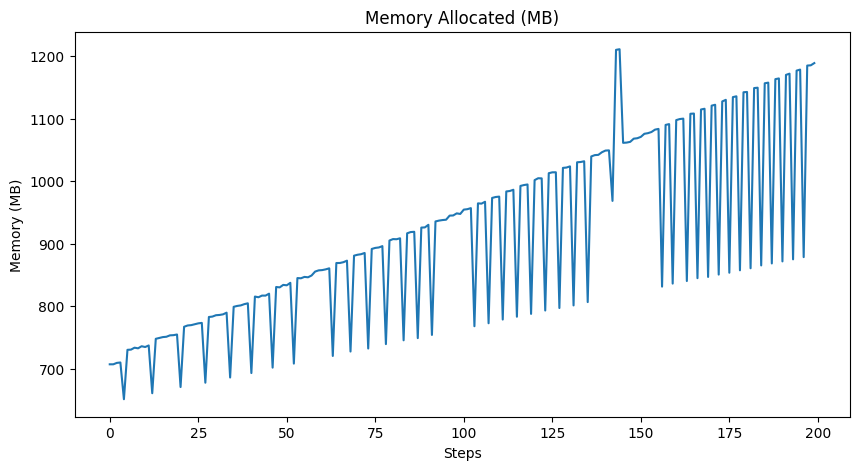

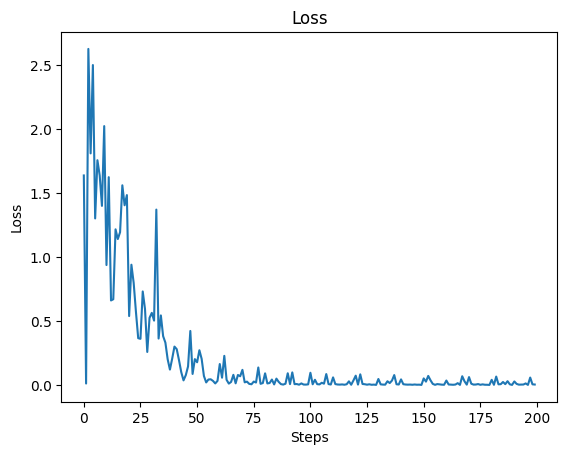

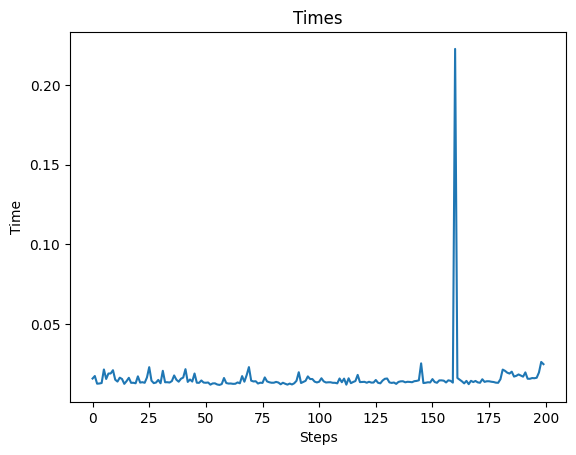

In [20]:
input_ids_batch = torch.stack([prompt['input_ids'] for prompt in left_padding_encoded_prompts]).to(device)
attention_mask_batch = torch.stack([prompt['attention_mask'] for prompt in left_padding_encoded_prompts]).to(device)
position_id_batch = torch.stack(position_ids).to(device)
print(input_ids_batch.shape)
# Define constants
MAX_TOKENS = 200

# Initialize lists to store metrics
times_batch = []
losses = []
memory_allocated = []


# Perform inference in a loop
start_time = time.time()
with torch.no_grad():
    past_key_values = None
    while len(input_ids_batch[0]) < max_length + MAX_TOKENS:
        start_step_time = time.time()

        # Model inference
        outputs = model(input_ids=input_ids_batch,
                        attention_mask=attention_mask_batch,
                        position_ids=position_id_batch
                        )

        # Get logits and predict next token
        logits = outputs.logits[:, -1, :]
        predicted_token_id = torch.argmax(logits, dim=-1)
        step_time = time.time() - start_step_time
        times_batch.append(step_time)

        # Append the predicted token to input_ids_batch
        input_ids_batch = torch.cat([input_ids_batch, predicted_token_id.unsqueeze(1)], dim=-1)

        # Update attention_mask_batch and position_id_batch
        attention_mask_batch = torch.cat([attention_mask_batch, torch.ones_like(predicted_token_id).unsqueeze(1)], dim=-1)

        max_position_id = torch.max(position_id_batch) + 1
        max_torch = torch.arange(max_position_id, max_position_id + 1).to(device)
        max_values = [position_id[-1].item() + 1 for position_id in position_id_batch]
        max_values_tensor = torch.tensor(max_values).unsqueeze(1).to(device)
        position_id_batch = torch.cat([position_id_batch, max_values_tensor], dim=-1)


        # Calculate loss (optional)
        loss = torch.nn.functional.cross_entropy(logits, predicted_token_id)
        losses.append(loss.item())

        # Store memory allocated
        memory_allocated.append(torch.cuda.memory_allocated() / (1024 ** 2))  # Convert bytes to MB

end_time_batch = time.time() - start_time
print(f"Total Time with past_key_values: {end_time_batch:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(memory_allocated)
plt.title("Memory Allocated (MB)")
plt.xlabel("Steps")
plt.ylabel("Memory (MB)")
plt.show()

plt.plot(losses)
plt.title("Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

plt.plot(times_batch)
plt.title("Times")
plt.xlabel("Steps")
plt.ylabel("Time")
plt.show()






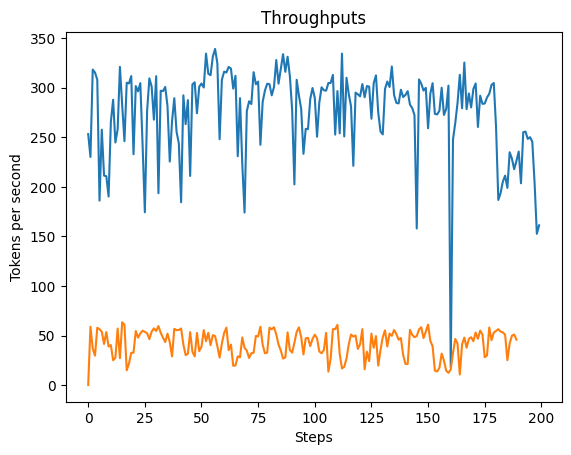

In [21]:
batch_size = len(prompts_list)
throughputs_batch = batch_size / np.array(times_batch)
throughputs_normal = 1 / np.array(times_normal)


plt.plot(throughputs_batch)
plt.plot(throughputs_normal)
plt.title("Throughputs")
plt.xlabel("Steps")
plt.ylabel("Tokens per second")
plt.show()

In [22]:
batch_size = len(prompts_list)
batch_throughput = MAX_TOKENS * batch_size / end_time_batch
single_throughput = MAX_TOKENS / end_time

print(f'Throughput ratio: {(batch_throughput / single_throughput):0.2}')

Throughput ratio: 3.7


there is a tradeoff here, if there is enough resources  ( GPU RAM ) we can use this method to get a better throughput.



# AI disclosure



*   how can i generate output using the prompt, and after each token generated, append the token and predict again.

for predicting the next word, use greedy decoding using torch module

and save the torch.cuda.max_memory_allocated and loss of each step ( predicting each word is a step) and plot it
*   now, i want to give the model the past_key_values to the model during generation, and repeat all of the above steps; then, compare the results

* RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

when im trying to input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

* what does past_key_values=past_key_values do
because it will make the generating prompt so fast

* i have a list of prompts, i want to encode them with left padding, Explain why left-side padding is preferable during inference. write the code to encode it

* what are positional encodings and how to add them to the model while generating text?

* now i want to create position_ids for these prompts for batch encoding

tell me what position_ids are used for and write the code for creating

* the model should used as this

    outputs = model(input_ids=input_ids_batch,
                    attention_mask=attention_mask_batch,
                    position_ids=position_id_batch
                    )

and update the attention_mask and position_ids too

* for updating
attention_mask_batch = torch.cat([attention_mask_batch, torch.ones_like(predicted_token_id).unsqueeze(1)], dim=-1)
        position_id_batch = torch.arange(len(input_ids_batch[0])).unsqueeze(0)

just add a 1 to attention and max_value + 1 of the position_ids to it

* """

def create_position_ids(batch_inputs): position_ids = [] for inputs in batch_inputs: input_ids = inputs['input_ids'] num_tokens = input_ids.size(0) position_ids.append(torch.arange(num_tokens)) return position_ids"""

change this function to for the first attention token that is 1

the sequnce starts

and before it ( 0 attenstions) use 1 for id

for example

if the attentions are

0, 0, 1, 1, 1, 1

the ids are

1, 1, 0, 1, 2, 3